In [1]:
import gensim
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pandas as pd

[nltk_data] Downloading package wordnet to /Users/ahara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# File sent in email
word2vec = gensim.models.KeyedVectors.load_word2vec_format('BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)
# https://github.com/ncbi-nlp/BioSentVec 1st download (13GB)
# word2vecPubMed = gensim.models.KeyedVectors.load_word2vec_format("FILE-NAME.bin.gz", binary=True)
# https://github.com/ncbi-nlp/BioSentVec 2nd download (21GB)
# sent2vecPubMed = gensim.models.KeyedVectors.load_word2vec_format("FILE-NAME.bin.gz", binary=True)

print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [3]:
tokenizer = RegexpTokenizer(r'\w+')

def doc_to_vec(sentence, word2vec):
    word_vecs = [word2vec.get_vector(w) for w in sentence.split() if w in word2vec.vocab]
    if len(word_vecs) != 0:
        stack = np.asarray(word_vecs).mean(0)
        if stack.all() != None:
            if isinstance(stack, (np.ndarray, np.generic)):
                return np.stack(stack)
            else:
                print("error")

def featurize(df, file):
    features = dict()
    for index, row in df.iterrows():
        # Change column header according to the csv file
        noteText = row['noteText']
        if isinstance(noteText, str):
            tokens = tokenizer.tokenize(noteText.lower())
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            my_string = ' '.join(tokens)
            googleVector = doc_to_vec(my_string, word2vec)
            features[row['mrn']] = googleVector
    featuresDF = pd.DataFrame(pd.Series(features).reset_index())
    featuresDF.to_csv(file, mode='a', header=False)

In [54]:
# Read in medical notes -- Change file name accordingly
colNames = ['mrn', 'noteType', 'noteText']
for chunk in pd.read_csv('merged_trainNotesAbridged.csv', header=None, error_bad_lines=False, chunksize=1000, names=colNames, encoding='latin-1'):
    featurize(chunk, "notesVectorized_pubmed.csv")

In [4]:
colNames = ['mrn', 'noteType', 'noteText']
for chunk in pd.read_csv('merged_devNotesAbridged.csv', header=None, error_bad_lines=False, chunksize=1000, skiprows=[0], names=colNames, encoding='latin-1'):
    featurize(chunk, "dev_notesVectorized_pubmed.csv")

In [20]:
import re

cols1=['index', 'mrn', 'vector']
cols2=['mrn', 'label']

notesW2V = pd.read_csv('notesVectorized_pubmed.csv', dtype=object, header=None, names=cols1)
labelsW2V = pd.read_csv('train_data.csv', header=None, names=cols2)

notesW2V['mrn'].replace('', np.nan, inplace=True)
notesW2V.dropna(subset=['mrn'], inplace=True)

notesW2V['mrn'] = notesW2V['mrn'].astype(int)
labelsW2V['mrn'] = labelsW2V['mrn'].astype(int)

notesAndLabelsW2V = pd.merge(notesW2V, labelsW2V, how='left', on=['mrn'])

kerasXW2V = []
kerasYW2V = []
for index, row in notesAndLabelsW2V.iterrows():
    vectorRow = []
    row2 = ""
    row2 = row['vector'].replace("[", '').replace("]", '')
    row2 = re.split('\\s+', row2)
    for i in row2:
        if i != "":
            vectorRow.append(float(i))
    kerasXW2V.append(vectorRow)
    kerasYW2V.append(row['label'])

print(len(kerasYW2V))

cols1=['index', 'mrn', 'vector']
cols2=['mrn', 'label']

notes2W2V = pd.read_csv('dev_notesVectorized_pubmed.csv', dtype=object, header=None, names=cols1)
labels2W2V = pd.read_csv('validate_data.csv', header=None, names=cols2)

notes2W2V['mrn'].replace('', np.nan, inplace=True)
notes2W2V.dropna(subset=['mrn'], inplace=True)

notes2W2V['mrn'] = notes2W2V['mrn'].astype(int)
labels2W2V['mrn'] = labels2W2V['mrn'].astype(int)

notesAndLabels2W2V = pd.merge(notes2W2V, labels2W2V, how='left', on=['mrn'])

kerasXDevW2V = []
kerasYDevW2V =[]
for index, row in notesAndLabels2W2V.iterrows():
    vectorRow = []
    row2 = ""
    row2 = row['vector'].replace("[", '').replace("]", '')
    row2 = re.split('\\s+', row2)
    for i in row2:
        if i != "":
            vectorRow.append(float(i))
    kerasXDevW2V.append(vectorRow)
    kerasYDevW2V.append(row['label'])
print(len(kerasYDevW2V))

6412
2139


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(stop_words='english')

In [22]:
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

notes= pd.read_csv('merged_trainNotesAbridged.csv', header=None, error_bad_lines=False, encoding='latin-1')
notes2= pd.read_csv('merged_devNotesAbridged.csv', header=None, error_bad_lines=False,encoding='latin-1')
notes3= pd.read_csv('merged-testNotesAbridged.csv', header=None, error_bad_lines=False, encoding='latin-1')

for index, row in notes.iterrows():
    if not isInt(row[1]):
        notes = notes.drop([index])

for index, row in notes2.iterrows():
    if not isInt(row[1]):
        notes2 = notes2.drop([index])
        
for index, row in notes3.iterrows():
    if not isInt(row[1]):
        notes3 = notes3.drop([index])

notes = notes.rename(columns={0: "index", 1: "mrn", 2: "noteType", 3: "noteText"})
notes2 = notes2.rename(columns={0: "index", 1: "mrn", 2: "noteType", 3: "noteText"})
notes3 = notes3.rename(columns={0: "index", 1: "mrn", 2: "noteType", 3: "noteText"})

In [23]:
notes

,index,mrn,noteType,noteText
1,0.0,000645514,Nursing Adult Admission History; Nursing Adult...,Preferred Language: \r\n\r\n Preferred Lang...
2,1.0,000738305,ED Adult Pre-Assessment Note; ED Adult Pre-Ass...,Triage Information: \r\n\r\n Triage Informa...
3,2.0,000816573,ED Patient Discharge Form; ED Patient Discharg...,Interpreter Services: \r\n\r\n Services Req...
4,3.0,000855972,ED Adult Pre-Assessment Note; ED Adult Pre-Ass...,Triage Information: \r\n\r\n Triage Informa...
5,4.0,000921689,Nursing Adult Admission History; Patient Disch...,Preferred Language: \r\n\r\n Preferred Lan...
...,...,...,...,...
6408,6407.0,086454304,ED Adult Pre-Assessment Note; ED Adult Pre-Ass...,Pollen Unknown \r\n\r\n I ha...
6409,6408.0,086628976,ED Adult Pre-Assessment Note; ED Adult Pre-Ass...,Patient preferred language: \r\n\r\n Prefer...
6410,6409.0,088307440,ED Patient Discharge Form; ED Patient Discharg...,Type Entered By Otitis media lef...
6411,6410.0,089681932,ED Unified Attending Note; ED Unified Attendin...,ablation (2010) anxiety(1) Past Surger...


In [24]:
import re

cols1=['index', 'mrn', 'noteType', 'noteText']
cols2=['mrn', 'label']

labels = pd.read_csv('train_data.csv', header=None, names=cols2)

notes['mrn'].replace('', np.nan, inplace=True)
notes.dropna(subset=['mrn'], inplace=True)

notes['mrn'] = notes['mrn'].astype(int)
labels['mrn'] = labels['mrn'].astype(int)

notesAndLabels = pd.merge(notes, labels, how='left', on=['mrn'])

kerasX = np.asarray(notesAndLabels['noteText'])
kerasY = np.asarray(notesAndLabels['label'])
print(len(kerasY))

cols1=['index', 'mrn', 'vector']
cols2=['mrn', 'label']

labels2 = pd.read_csv('validate_data.csv', header=None, names=cols2)

notes2['mrn'].replace('', np.nan, inplace=True)
notes2.dropna(subset=['mrn'], inplace=True)

notes2['mrn'] = notes2['mrn'].astype(int)
labels2['mrn'] = labels2['mrn'].astype(int)

notesAndLabels2 = pd.merge(notes2, labels2, how='left', on=['mrn'])

kerasXDev = np.asarray(notesAndLabels2['noteText'])
kerasYDev = np.asarray(notesAndLabels2['label'])
print(len(kerasYDev))

labels3 = pd.read_csv('test_data.csv', header=None, names=cols2)

notes3['mrn'].replace('', np.nan, inplace=True)
notes3.dropna(subset=['mrn'], inplace=True)

notes3['mrn'] = notes3['mrn'].astype(int)
labels3['mrn'] = labels3['mrn'].astype(int)

notesAndLabels3 = pd.merge(notes3, labels3, how='left', on=['mrn'])

kerasXTest = np.asarray(notesAndLabels3['noteText'])
kerasYTest = np.asarray(notesAndLabels3['label'])

6412
2139


In [7]:
count = 0
for i in kerasYDev:
    if i == 1:
        count += 1
print(count)

117


In [25]:
X = vectorizer.fit_transform(kerasX)
Xpred = vectorizer.transform(kerasXDev)
Xtest = vectorizer.transform(kerasXTest)

In [39]:
def accuracy(y_pred,y):
    predictions = []
    for i in y_pred:
        if i > .5:
            predictions.append(1)
        else:
            predictions.append(0)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)

    print(accuracy)
    print(precision)
    print(recall)

In [37]:
test = [0] * len(kerasYDevW2VG)
accuracy(test, kerasYDevW2VG)

0.9453015427769986
0.0
0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
def knn(n):
    y_pred=[]
    knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    knn.fit(X, kerasY)
    
    y_pred = knn.predict(Xpred)
    accuracy(y_pred, kerasYDevW2VG)

In [32]:
for i in range(1,20):
    knn(i)

0.9130434782608695
0.38461538461538464
0.2830188679245283
0.9406264609630669
0.08547008547008547
0.3333333333333333
0.9345488546049556
0.3076923076923077
0.37894736842105264
0.9467040673211781
0.11965811965811966
0.56
0.9429640018700327
0.21367521367521367
0.45454545454545453
0.946236559139785
0.08547008547008547
0.5555555555555556
0.949041608228144
0.20512820512820512
0.6
0.9467040673211781
0.08547008547008547
0.5882352941176471
0.9467040673211781
0.1452991452991453
0.5483870967741935
0.9453015427769986
0.06837606837606838
0.5
0.9443665264142123
0.1282051282051282
0.46875
0.9448340345956054
0.07692307692307693
0.47368421052631576
0.9443665264142123
0.1111111111111111
0.4642857142857143
0.9457690509583918
0.06837606837606838
0.5333333333333333
0.9443665264142123
0.10256410256410256
0.46153846153846156
0.9457690509583918
0.06837606837606838
0.5333333333333333
0.9457690509583918
0.09401709401709402
0.5238095238095238
0.9467040673211781
0.05128205128205128
0.6666666666666666
0.94623655913

In [60]:
def clusters(n):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(kerasXW2VG)
    y_pred = kmeans.predict(kerasXDevW2VG)
    accuracy(y_pred, kerasYDevW2VG)
    print("-----")

for i in range(10,20):
    clusters(i)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=1000000, random_state=0)
clf.fit(kerasXW2VG, kerasYW2VG)
y_pred = clf.predict(kerasXDevW2VG)
accuracy(y_pred, kerasYDevW2VG)

0.9476390836839644
0.05982905982905983
0.7777777777777778


In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=None, max_iter=1000, verbose=True).fit(X, kerasY)
y_pred = clf.predict(Xpred)

print(clf.score(Xpred, kerasYDev, sample_weight=None))

Iteration 1, loss = 0.31926461
Iteration 2, loss = 0.20723282
Iteration 3, loss = 0.18370183
Iteration 4, loss = 0.16440194
Iteration 5, loss = 0.14835305
Iteration 6, loss = 0.13646676
Iteration 7, loss = 0.12660016
Iteration 8, loss = 0.11746249
Iteration 9, loss = 0.10918876
Iteration 10, loss = 0.10162657
Iteration 11, loss = 0.09511954
Iteration 12, loss = 0.08859449
Iteration 13, loss = 0.08433768
Iteration 14, loss = 0.07854424
Iteration 15, loss = 0.07398583
Iteration 16, loss = 0.06979172
Iteration 17, loss = 0.06626446
Iteration 18, loss = 0.06348556
Iteration 19, loss = 0.06083681
Iteration 20, loss = 0.05883967
Iteration 21, loss = 0.05675556
Iteration 22, loss = 0.05511104
Iteration 23, loss = 0.05331348
Iteration 24, loss = 0.05173317
Iteration 25, loss = 0.05053320
Iteration 26, loss = 0.04919189
Iteration 27, loss = 0.04779181
Iteration 28, loss = 0.04657928
Iteration 29, loss = 0.04541263
Iteration 30, loss = 0.04442435
Iteration 31, loss = 0.04340680
Iteration 32, los

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


TypeError: 'numpy.float64' object is not callable

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(kerasYDev, y_pred)
precision = precision_score(kerasYDev, y_pred)
recall = recall_score(kerasYDev, y_pred)

print(accuracy)
print(precision)
print(recall) # recall is accuracy of homeless notes

NameError: name 'y_pred' is not defined

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(hidden_layer_sizes=(100, ), random_state=None, max_iter=500, verbose=True).fit(kerasXW2V, kerasYW2V)
y_pred = clf.predict(kerasXDevW2V)
accuracy(y_pred)

print(clf.score(kerasXDevW2V, kerasYDevW2V, sample_weight=None))

Iteration 1, loss = 0.29797395
Iteration 2, loss = 0.23467652
Iteration 3, loss = 0.23156494
Iteration 4, loss = 0.22906956
Iteration 5, loss = 0.22729047
Iteration 6, loss = 0.22515532
Iteration 7, loss = 0.22336600
Iteration 8, loss = 0.22101825
Iteration 9, loss = 0.21827558
Iteration 10, loss = 0.21606945
Iteration 11, loss = 0.21337450
Iteration 12, loss = 0.21305489
Iteration 13, loss = 0.20939887
Iteration 14, loss = 0.20746236
Iteration 15, loss = 0.20592017
Iteration 16, loss = 0.20543420
Iteration 17, loss = 0.20468159
Iteration 18, loss = 0.20161754
Iteration 19, loss = 0.20200271
Iteration 20, loss = 0.19921743
Iteration 21, loss = 0.19804313
Iteration 22, loss = 0.19658539
Iteration 23, loss = 0.19585630
Iteration 24, loss = 0.19539838
Iteration 25, loss = 0.19392625
Iteration 26, loss = 0.19203935
Iteration 27, loss = 0.19177384
Iteration 28, loss = 0.19072766
Iteration 29, loss = 0.18949796
Iteration 30, loss = 0.18848195
Iteration 31, loss = 0.18664175
Iteration 32, los

In [261]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)

XUnigram = vectorizer.fit_transform(kerasX)
XPredUnigram = vectorizer.transform(kerasXDev)
XBigram = bigram_vectorizer.fit_transform(kerasX)
XPredBigram = bigram_vectorizer.transform(kerasXDev)

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(max_iter=50)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'sigmoid'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'verbose': [True]
}
parameter_space2 = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [.05],
    'learning_rate': ['constant'],
    'verbose': [True]
}
# clf = GridSearchCV(mlp, parameter_space2, n_jobs=-1, cv=3)
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', alpha=.1, random_state=None, max_iter=500, verbose=True).fit(kerasXW2V, kerasYW2V)

clf.fit(XUnigram, kerasY)
print('Best parameters found:\n', clf.best_params_)

y_pred = clf.predict(XPredUnigram)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Iteration 1, loss = 1.41079023
Iteration 2, loss = 0.34481967
Iteration 3, loss = 0.20928905
Iteration 4, loss = 0.11177316
Iteration 5, loss = 0.09402893
Iteration 6, loss = 0.08595530
Iteration 7, loss = 0.07006549
Iteration 8, loss = 0.06156909
Iteration 9, loss = 0.05518281
Iteration 10, loss = 0.07142498
Iteration 11, loss = 0.07134009
Iteration 12, loss = 0.04937283
Iteration 13, loss = 0.04451961
Iteration 14, loss = 0.04167503
Iteration 15, loss = 0.03963054
Iteration 16, loss = 0.05614215
Iteration 17, loss = 0.04829761
Iteration 18, loss = 0.03987722
Iteration 19, loss = 0.03593728
Iteration 20, loss = 0.03379092
Iteration 21, loss = 0.03241817
Iteration 22, loss = 0.03087199
Iteration 23, loss = 0.02979729
Iteration 24, loss = 0.02880739
Iteration 25, loss = 0.02831421
Iteration 26, loss = 0.02741464
Iteration 27, loss = 0.02683284
Iteration 28, loss = 0.02596933
Iteration 29, loss = 0.02548347
Iteration 30, loss = 0.02520670
Iteration 31, loss = 0.02401970
Iteration 32, los

In [45]:
countRight = 0
countOf1 = 0

print(len(y_pred))

for k in range(len(y_pred)):
    if y_pred[k] == kerasYDev[k]:
        countRight += 1
        if kerasYDev[k] == 1:
            countOf1 += 1

accuracy = countRight/2139
homelessAccuracy = countOf1/117

print(accuracy)
print(homelessAccuracy)
print(countOf1)

2139
0.9504441327723235
0.29914529914529914
35


In [46]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(kerasYDev, y_pred)
precision = precision_score(kerasYDev, y_pred)
recall = recall_score(kerasYDev, y_pred)

print(accuracy)
print(precision)
print(recall) # recall is accuracy of homeless notes


0.9504441327723235
0.5932203389830508
0.29914529914529914


In [66]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', alpha=.05, random_state=None, max_iter=500, verbose=True)

clf.fit(X, kerasY)
y_pred = clf.predict_proba(Xpred)
y_test = clf.predict_proba(Xtest)

Iteration 1, loss = 0.35899351
Iteration 2, loss = 0.22965590
Iteration 3, loss = 0.21094047
Iteration 4, loss = 0.19982007
Iteration 5, loss = 0.19122671
Iteration 6, loss = 0.18520706
Iteration 7, loss = 0.18042573
Iteration 8, loss = 0.17641142
Iteration 9, loss = 0.17407182
Iteration 10, loss = 0.17146092
Iteration 11, loss = 0.16785741
Iteration 12, loss = 0.16621674
Iteration 13, loss = 0.16461316
Iteration 14, loss = 0.16237088
Iteration 15, loss = 0.15997585
Iteration 16, loss = 0.15971386
Iteration 17, loss = 0.15677006
Iteration 18, loss = 0.15509859
Iteration 19, loss = 0.15378213
Iteration 20, loss = 0.15377405
Iteration 21, loss = 0.15197781
Iteration 22, loss = 0.15035555
Iteration 23, loss = 0.14932006
Iteration 24, loss = 0.14857442
Iteration 25, loss = 0.14697457
Iteration 26, loss = 0.14589999
Iteration 27, loss = 0.14515216
Iteration 28, loss = 0.14452872
Iteration 29, loss = 0.14374397
Iteration 30, loss = 0.14245342
Iteration 31, loss = 0.14103111
Iteration 32, los

In [69]:
y_pred = clf.predict_proba(Xpred)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

predictions = []
for i in y_pred:
    if i[0] > .75:
        predictions.append(0)
    else:
        predictions.append(1)

accuracy = accuracy_score(kerasYDev, predictions)
precision = precision_score(kerasYDev, predictions)
recall = recall_score(kerasYDev, predictions)

print(accuracy)
print(precision)
print(recall)

0.9513791491351099
0.5643564356435643
0.48717948717948717


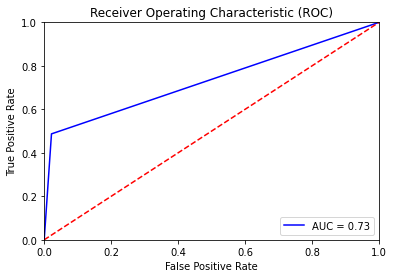

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(kerasYDev, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
predictionsTest = []
for i in y_test:
    if i[0] > .75:
        predictionsTest.append(0)
    else:
        predictionsTest.append(1)

accuracy = accuracy_score(kerasYTest, predictionsTest)
precision = precision_score(kerasYTest, predictionsTest)
recall = recall_score(kerasYTest, predictionsTest)

print(accuracy)
print(precision)
print(recall)

0.949200376293509
0.6185567010309279
0.4580152671755725


In [313]:
# Predicted landscape of our data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

test_data_keras_PCA = pca.fit_transform(Xpred)
class1 = []
class2 = []

for a in range(len(Xpred)):
    if predictions[a] == 1:
        class1.append(test_data_keras_PCA[a])
    else:
        class2.append(test_data_keras_PCA[a])
                         
plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
# plt.xlim(-.4, 1.4)
# plt.ylim(-.6, .6)
plt.show()

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), random_state=None, max_iter=1000, verbose=True).fit(XBigram, kerasY)
y_pred = clf.predict(XPredBigram)
accuracy(y_pred)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
accuracy = accuracy_score(kerasYDev, y_pred)
precision = precision_score(kerasYDev, y_pred)
recall = recall_score(kerasYDev, y_pred)

print(accuracy)
print(precision)
print(recall)

In [25]:
homelessWords = [
    "undomicile",
    "homeless",
    "unhoused",
]

y_pred=[]
count = 0

for index, row in notesAndLabels2.iterrows():
    homeless = False
    for i in homelessWords:
        if i in row['noteText']:
            homeless = True
    if homeless:
        y_pred.append(1)
        count += 1
    else:
        y_pred.append(0)
print(count)

169


In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(kerasYDev, y_pred)
precision = precision_score(kerasYDev, y_pred)
recall = recall_score(kerasYDev, y_pred)

print(accuracy)
print(precision)
print(recall)

0.9280037400654512
0.3905325443786982
0.5641025641025641


In [47]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=0)

model = Sequential()
model.add(Dense(128, input_dim=200, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=adam)

model.fit(kerasX, kerasY, epochs=200, batch_size=400, verbose=1)

InvalidArgumentError: indices[1] = [0,2061547] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [30]:
import re

cols1=['index', 'mrn', 'vector']
cols2=['mrn', 'label']

notesW2VG = pd.read_csv('notesVectorized.csv', dtype=object, header=None, names=cols1)
labelsW2VG = pd.read_csv('train_data.csv', header=None, names=cols2)

notesW2VG['mrn'].replace('', np.nan, inplace=True)
notesW2VG.dropna(subset=['mrn'], inplace=True)

notesW2VG['mrn'] = notesW2VG['mrn'].astype(int)
labelsW2VG['mrn'] = labelsW2VG['mrn'].astype(int)

notesAndLabelsW2VG = pd.merge(notesW2VG, labelsW2VG, how='left', on=['mrn'])

kerasXW2VG = []
kerasYW2VG = []
for index, row in notesAndLabelsW2VG.iterrows():
    vectorRow = []
    row2 = ""
    row2 = row['vector'].replace("[", '').replace("]", '')
    row2 = re.split('\\s+', row2)
    for i in row2:
        if i != "":
            vectorRow.append(float(i))
    kerasXW2VG.append(vectorRow)
    kerasYW2VG.append(row['label'])

print(len(kerasXW2VG[0]))

cols1=['index', 'mrn', 'vector']
cols2=['mrn', 'label']

notes2W2VG = pd.read_csv('dev_notesVectorized.csv', dtype=object, header=None, names=cols1)
labels2W2VG = pd.read_csv('validate_data.csv', header=None, names=cols2)

notes2W2VG['mrn'].replace('', np.nan, inplace=True)
notes2W2VG.dropna(subset=['mrn'], inplace=True)

notes2W2VG['mrn'] = notes2W2VG['mrn'].astype(int)
labels2W2VG['mrn'] = labels2W2VG['mrn'].astype(int)

notesAndLabels2W2VG = pd.merge(notes2W2VG, labels2W2V, how='left', on=['mrn'])

kerasXDevW2VG = []
kerasYDevW2VG =[]
for index, row in notesAndLabels2W2VG.iterrows():
    vectorRow = []
    row2 = ""
    row2 = row['vector'].replace("[", '').replace("]", '')
    row2 = re.split('\\s+', row2)
    for i in row2:
        if i != "":
            vectorRow.append(float(i))
    kerasXDevW2VG.append(vectorRow)
    kerasYDevW2VG.append(row['label'])
print(len(kerasYDevW2VG))

300
2139


In [52]:
adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=0)

model = Sequential()
model.add(Dense(300, input_dim=300, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer="adam")

model.fit(kerasXW2VG, kerasYW2VG, epochs=1000, batch_size=300, verbose=1)

# 0.9429640018700327
# 0.8803418803418803
# 103

Epoch 1/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.1197
Epoch 2/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 3/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0588
Epoch 4/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 5/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 6/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0588
Epoch 7/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0588
Epoch 8/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0588
Epoch 9/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 10/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 11/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 12/1000
22/22 [==============================] - 0s 8ms/step - loss: 0.0588
Epoch 13/1000
22/22 [====

Epoch 101/1000
22/22 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 102/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 103/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 104/1000
22/22 [==============================] - 0s 4ms/step - loss: 0.0503
Epoch 105/1000
22/22 [==============================] - 0s 4ms/step - loss: 0.0510
Epoch 106/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 107/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0500
Epoch 108/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 109/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0492
Epoch 110/1000
22/22 [==============================] - 0s 4ms/step - loss: 0.0489
Epoch 111/1000
22/22 [==============================] - 0s 4ms/step - loss: 0.0487
Epoch 112/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0483
Epoc

22/22 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 298/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.0436
Epoch 299/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 300/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 301/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 302/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0433
Epoch 303/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 304/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0436
Epoch 305/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.0438
Epoch 306/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 307/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 308/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 309/1000
22/2

22/22 [==============================] - 0s 6ms/step - loss: 0.0412
Epoch 494/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.0414
Epoch 495/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 496/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 497/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 498/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 499/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0412
Epoch 500/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.0413
Epoch 501/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 502/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0416
Epoch 503/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0433
Epoch 504/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0419
Epoch 505/1000
22/2

KeyboardInterrupt: 

In [53]:
accuracy = accuracy_score(kerasYDev, y_pred)
precision = precision_score(kerasYDev, y_pred)
recall = recall_score(kerasYDev, y_pred)

print(accuracy)
print(precision)
print(recall)

0.9457690509583918
0.5263157894736842
0.08547008547008547


In [127]:
# mlp = MLPClassifier(max_iter=50)
# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu', 'sigmoid'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
#     'verbose': [True]
# }
# parameter_space2 = {
#     'hidden_layer_sizes': [(100,)],
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'alpha': [.05],
#     'learning_rate': ['constant'],
#     'verbose': [True]
# }
# clf = GridSearchCV(mlp, parameter_space2, n_jobs=-1, cv=3)
clf = MLPClassifier(hidden_layer_sizes=(10000,100,100 ), activation='tanh', alpha=.00001, random_state=None, max_iter=500, verbose=True)

clf.fit(kerasXW2VG, kerasYW2VG)
y_pred = clf.predict(kerasXDevW2VG)

Iteration 1, loss = 0.25616103
Iteration 2, loss = 0.20833713
Iteration 3, loss = 0.21988615
Iteration 4, loss = 0.19513966
Iteration 5, loss = 0.18433653
Iteration 6, loss = 0.18874768
Iteration 7, loss = 0.17984454
Iteration 8, loss = 0.19068481
Iteration 9, loss = 0.17995137
Iteration 10, loss = 0.17245068
Iteration 11, loss = 0.17142375
Iteration 12, loss = 0.18456266
Iteration 13, loss = 0.16879960
Iteration 14, loss = 0.17171872
Iteration 15, loss = 0.17968191
Iteration 16, loss = 0.17054836
Iteration 17, loss = 0.16755943
Iteration 18, loss = 0.16857990
Iteration 19, loss = 0.16365501
Iteration 20, loss = 0.17612061
Iteration 21, loss = 0.16391529
Iteration 22, loss = 0.16314799
Iteration 23, loss = 0.16181412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [129]:
accuracy = accuracy_score(kerasYDevW2VG, y_pred)
precision = precision_score(kerasYDevW2VG, y_pred)
recall = recall_score(kerasYDevW2VG, y_pred)

print(accuracy)
print(precision)
print(recall)

# 0.9387564282374942
# 0.3870967741935484
# 0.20512820512820512

0.946236559139785
0.5416666666666666
0.1111111111111111


In [ ]:
# On dev set, if accuracy = 0.9453015427769986, model is predicting all 0s
# 0.9503026441541892

y_pred_keras = model.predict_proba(kerasXDev)

countRight = 0
countOf1 = 0

predictions = []
for i in y_pred_keras:
    if i < .5:
        predictions.append(0)
    else:
        predictions.append(1)

for k in range(len(predictions)):
    if predictions[k] == kerasYDev[k]:
        countRight += 1
        if kerasYDev[k] == 1:
            countOf1 += 1

accuracy = countRight/2139
homelessAccuracy = countOf1/70

print(accuracy)
print(homelessAccuracy)
print(countOf1)

In [ ]:
# Predicted landscape of our data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

test_data_keras_PCA = pca.fit_transform(kerasXDev)
class1 = []
class2 = []

for a in range(len(kerasXDev)-1):
    if predictions[a] == 1:
        class1.append(test_data_keras_PCA[a])
    else:
        class2.append(test_data_keras_PCA[a])
                         
plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
# plt.xlim(-.4, 1.4)
# plt.ylim(-.6, .6)
plt.show()

In [ ]:
# True landscape of our data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

test_data_keras_PCA = pca.fit_transform(kerasXDev)
class1 = []
class2 = []

for a in range(len(kerasYDev)-1):
    if kerasYDev[a] == 1:
        class1.append(test_data_keras_PCA[a])
    else:
        class2.append(test_data_keras_PCA[a])
                         
plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
# plt.xlim(-.4, 1.4)
# plt.ylim(-.6, .6)
plt.show()

In [ ]:
# True landscape of our data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

train_data_keras_PCA = pca.fit_transform(kerasX)
class1 = []
class2 = []

for a in range(len(kerasY)-1):
    if kerasY[a] == 1:
        class1.append(test_data_keras_PCA[a])
    else:
        class2.append(test_data_keras_PCA[a])
                         
plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
# plt.xlim(-.4, 1.4)
# plt.ylim(-.6, .6)
plt.show()

In [156]:
overallDataX = []

for i in range(len(kerasXW2V)):
    empty=[]
    empty = kerasXW2VG[i]+kerasXW2V[i]
    overallDataX.append(empty)
    
overallDataXDev = []
for i in range(len(kerasXDevW2V)):
    empty=[]
    empty = kerasXDevW2VG[i]+kerasXDevW2V[i]
    overallDataXDev.append(empty)

In [157]:
print(len(overallDataX[0]))

500


In [199]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(hidden_layer_sizes=(1000, ), activation='tanh', learning_rate_init=0.005, random_state=None, max_iter=500, verbose=True)

clf.fit(overallDataX, kerasYW2V)
y_pred = clf.predict(overallDataXDev)

Iteration 1, loss = 0.41299624
Iteration 2, loss = 0.24205692
Iteration 3, loss = 0.22432972
Iteration 4, loss = 0.20598508
Iteration 5, loss = 0.21859361
Iteration 6, loss = 0.19745572
Iteration 7, loss = 0.18884586
Iteration 8, loss = 0.19099534
Iteration 9, loss = 0.21217940
Iteration 10, loss = 0.18650827
Iteration 11, loss = 0.19064141
Iteration 12, loss = 0.19462621
Iteration 13, loss = 0.18215107
Iteration 14, loss = 0.18167902
Iteration 15, loss = 0.19710512
Iteration 16, loss = 0.18511896
Iteration 17, loss = 0.18005635
Iteration 18, loss = 0.19329563
Iteration 19, loss = 0.17690957
Iteration 20, loss = 0.19834587
Iteration 21, loss = 0.17913410
Iteration 22, loss = 0.17418975
Iteration 23, loss = 0.18722590
Iteration 24, loss = 0.17687071
Iteration 25, loss = 0.17164413
Iteration 26, loss = 0.17610248
Iteration 27, loss = 0.17357599
Iteration 28, loss = 0.17190061
Iteration 29, loss = 0.18855105
Iteration 30, loss = 0.17286886
Iteration 31, loss = 0.17379442
Iteration 32, los

In [200]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(kerasYDevW2VG, y_pred)
precision = precision_score(kerasYDevW2VG, y_pred)
recall = recall_score(kerasYDevW2VG, y_pred)

print(accuracy)
print(precision)
print(recall)

# clf = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', learning_rate_init=0.009, random_state=None, max_iter=500, verbose=True)

# 0.8279569892473119
# 0.4444444444444444
# 0.8205128205128205

0.9453015427769986
0.4444444444444444
0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=0)

model = Sequential()
model.add(Dense(1, input_dim=300, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer="adam")

model.fit(kerasXW2VG, kerasYW2VG, epochs=100, batch_size=250)
y_pred=model.predict(kerasXDevW2VG)
preds=[]
for i in y_pred:
    if i[0] > .5:
        preds.append(1)
    else:   
        preds.append(0)
accuracy(preds, kerasYDevW2VG)

Epoch 1/100
26/26 [==============================] - 0s 1ms/step - loss: 0.2146
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1597
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 0.1236
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1015
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 7/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0737
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 9/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0672
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0653
Epoch 11/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 12/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0628
Epoch 13/100
26/26 [=================

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [196]:
predictions = []
for i in y_pred:
    if i < .5:
        predictions.append(0)
    else:
        predictions.append(1)

accuracy = accuracy_score(kerasYDevW2VG, predictions)
# precision_score = precision_score(kerasYDevW2VG, predictions)
recall = recall_score(kerasYDevW2VG, predictions)

print(accuracy)
# print(precision)
print(recall)

0.9476390836839644
0.08547008547008547


In [54]:
print(preds)

[0.05190447, 0.048850864, 0.051793218, 0.058837682, 0.058488905, 0.048933953, 0.059798837, 0.036573887, 0.047164887, 0.11070764, 0.06680304, 0.05262333, 0.053738177, 0.06020829, 0.057163805, 0.046044797, 0.094379604, 0.05159211, 0.10232422, 0.054990083, 0.061270922, 0.063501894, 0.059171736, 0.05167553, 0.06019509, 0.12695673, 0.05048418, 0.04174769, 0.050454855, 0.08191979, 0.056955844, 0.10240689, 0.07495022, 0.048793614, 0.07581258, 0.039911777, 0.08269456, 0.05784583, 0.051147938, 0.048368633, 0.050542325, 0.058942914, 0.04372579, 0.053551733, 0.05082959, 0.09808704, 0.05892098, 0.086536944, 0.047336638, 0.044496775, 0.073434144, 0.08322695, 0.06321496, 0.060032368, 0.063346505, 0.057533205, 0.084082484, 0.056800455, 0.048806846, 0.06578469, 0.051249146, 0.08184478, 0.07232675, 0.07619488, 0.06673145, 0.07798937, 0.05144617, 0.06643531, 0.062042594, 0.091266036, 0.08244115, 0.06131506, 0.050387353, 0.08990711, 0.052901268, 0.091807246, 0.09511432, 0.051769555, 0.06888148, 0.1263580

In [209]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (250,), (500,) ],
    'activation': ['tanh', 'relu', 'sigmoid'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, .005, .0005],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.01, .001, .005, .0001, .0005, .00001],
    'verbose': [True]
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(overallDataX, kerasYW2V)
y_pred = clf.predict(overallDataXDev)

Iteration 1, loss = 0.37895499
Iteration 2, loss = 0.21935842
Iteration 3, loss = 0.21237948
Iteration 4, loss = 0.20388629
Iteration 5, loss = 0.20679686
Iteration 6, loss = 0.19861788
Iteration 7, loss = 0.19251979
Iteration 8, loss = 0.18577758
Iteration 9, loss = 0.18734341
Iteration 10, loss = 0.18314035
Iteration 11, loss = 0.24255371
Iteration 12, loss = 0.18793118
Iteration 13, loss = 0.18473389
Iteration 14, loss = 0.18044678
Iteration 15, loss = 0.17987966
Iteration 16, loss = 0.18516261
Iteration 17, loss = 0.19398217
Iteration 18, loss = 0.17686959
Iteration 19, loss = 0.17729695
Iteration 20, loss = 0.18568534
Iteration 21, loss = 0.18118245
Iteration 22, loss = 0.17870537
Iteration 23, loss = 0.17436809
Iteration 24, loss = 0.18400726
Iteration 25, loss = 0.17788367
Iteration 26, loss = 0.18032708
Iteration 27, loss = 0.17964557
Iteration 28, loss = 0.16753421
Iteration 29, loss = 0.17045854
Iteration 30, loss = 0.18782817
Iteration 31, loss = 0.17504088
Iteration 32, los

In [211]:
accuracy = accuracy_score(kerasYDevW2VG, predictions)
# precision_score = precision_score(kerasYDevW2VG, predictions)
recall = recall_score(kerasYDevW2VG, predictions)

print(accuracy)
# print(precision)
print(recall)

0.9476390836839644
0.08547008547008547


In [258]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 36, 1), random_state=1)
# clf.fit(X, y)

y_pred = clf.predict_proba(overallDataXDev)
predictions = []
for i in y_pred:
    if i[0] > .9:
        predictions.append(0)
    else:
        predictions.append(1)

In [259]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(kerasYDevW2VG, predictions)
precision = precision_score(kerasYDevW2VG, predictions)
recall = recall_score(kerasYDevW2VG, predictions)

print(accuracy)
print(precision)
print(recall)

0.8536699392239364
0.24345549738219896
0.7948717948717948


In [ ]:
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

cols1=['index', 'mrn', 'vector']

notes3= pd.read_csv('merged-testNotesAbridged.csv', header=None, error_bad_lines=False, nrows=6412, encoding='latin-1')

for index, row in notes3.iterrows():
    if not isInt(row[1]):
        notes3 = notes3.drop([index])

notes3 = notes2.rename(columns={0: "index", 1: "mrn", 2: "noteType", 3: "noteText"})


In [ ]:
import re

cols1=['index', 'mrn', 'noteType', 'noteText']
cols2=['mrn', 'label']

labels = pd.read_csv('test_data.csv', header=None, names=cols2)

notes['mrn'].replace('', np.nan, inplace=True)
notes.dropna(subset=['mrn'], inplace=True)

notes['mrn'] = notes['mrn'].astype(int)
labels['mrn'] = labels['mrn'].astype(int)

notesAndLabels = pd.merge(notes, labels, how='left', on=['mrn'])

kerasX = np.asarray(notesAndLabels['noteText'])
kerasY = np.asarray(notesAndLabels['label'])
print(len(kerasY))

In [ ]:
X = vectorizer.fit_transform(kerasX)
Xpred = vectorizer.transform(kerasXDev)